**Research plan**
 1. Feature and data explanation 
 2. Primary data analysis
 3. Primary visual data analysis
 4. Insights and found dependencies
 5. Metrics selection
 6. Model selection
 7. Data preprocessing
 8. Cross-validation and adjustment of model hyperparameters
 9. Creation of new features and description of this process
 10. Plotting training and validation curves
 11. Prediction for test or hold-out samples 
 12. Conclusions 

### Part 1. Feature and data explanation 

There are provided hourly rental data spanning two years. For this [competition](https://www.kaggle.com/c/comp180bikeshare), the [training set](https://www.kaggle.com/c/comp180bikeshare/data) is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or it's components "casual" and "registered".

**Data Fields**

* *datetime* - hourly date + timestamp
* *season* - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* *holiday* - whether the day is considered a holiday
* *workingday* - whether the day is neither a weekend nor holiday
* *weather* - 
    1.  Clear, Few clouds, Partly cloudy, Partly cloudy
    2.  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3.  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4.  Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* *temp* - temperature in Celsius
* *atemp* - "feels like" temperature in Celsius
* *humidity* - relative humidity
* *windspeed* - wind speed
* *casual* - number of non-registered user rentals initiated
* *registered* - number of registered user rentals initiated
* *count* - number of total rentals

### Part 2. Primary data analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Fixing random seed
np.random.seed(17)

print(os.listdir("../input"))

['tutorial_code.R', 'train_luc.csv', 'tutorial_code.ipynb', 'sample_prediction.csv', 'test_luc.csv']


In [2]:
# Fixing random seed
np.random.seed(17)
# Read data
data_df = pd.read_csv('../input/train_luc.csv')

# Convert to datetime
data_df['datetime'] = pd.to_datetime(data_df['datetime'])

# Sort by datetime
data_df.sort_values(by='datetime')

# Look at the first rows of the training set
data_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
data_df.shape

(9174, 12)

*Train contains 3 target columns:  ** 'casual', 'registred', 'count'.**
Column 'count' is the sum of columns 'casual' and 'registred'. Check it:*

In [4]:
(data_df['casual'] + data_df['registered'] - data_df['count']).value_counts()

0    9174
dtype: int64

In [5]:
# Get info by train
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174 entries, 0 to 9173
Data columns (total 12 columns):
datetime      9174 non-null datetime64[ns]
season        9174 non-null int64
holiday       9174 non-null int64
workingday    9174 non-null int64
weather       9174 non-null int64
temp          9174 non-null float64
atemp         9174 non-null float64
humidity      9174 non-null int64
windspeed     9174 non-null float64
casual        9174 non-null int64
registered    9174 non-null int64
count         9174 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 860.1 KB


Excelent! We have not NaN.

In [6]:
# Get statistics by train_df
data_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


### Part 3. Primary visual data analysis

I split data into train and hold-out samples 

In [7]:
train_df, test_df, y_train, y_test = train_test_split(data_df.drop(['casual', 'registered', 'count'], axis=1), data_df[['casual', 'registered', 'count']], 
                                                      test_size=0.3, random_state=17, shuffle=True)

In [8]:
def draw_train_test_distribution(column):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    sns.distplot(train_df[column], ax = axes[0], label='train')
    sns.distplot(test_df[column], ax = axes[1], label='test');

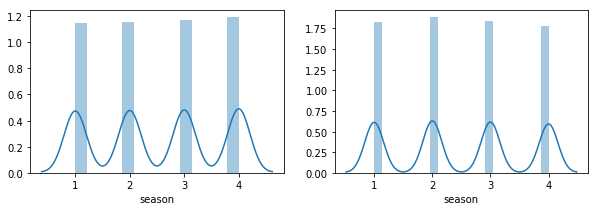

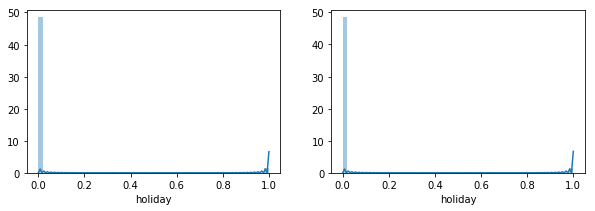

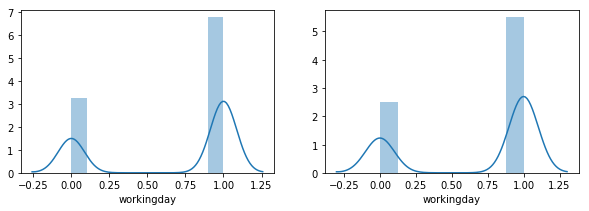

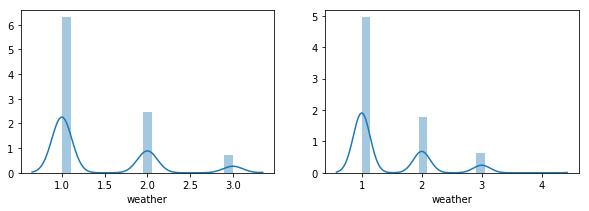

In [9]:
# The distribution of the indicative features
draw_train_test_distribution('season')
draw_train_test_distribution('holiday')
draw_train_test_distribution('workingday')
draw_train_test_distribution('weather');


The distribution of the indicative features ('season', 'holiday', 'workingday', 'weather') on the train and test coincides. There is 'weather' with value 4 on the test and absent on the train

In [10]:
test_df[test_df['weather'] == 4]['weather'].count()

1

Only 1 exampe contains 'weather'=4.  This can be neglected

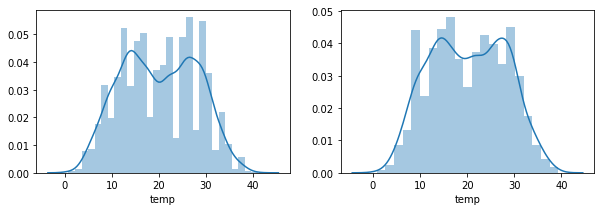

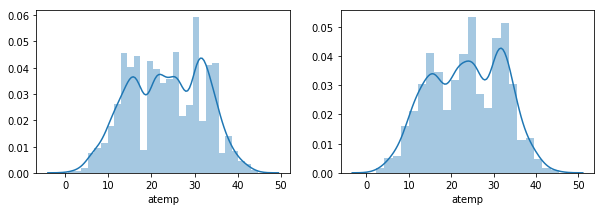

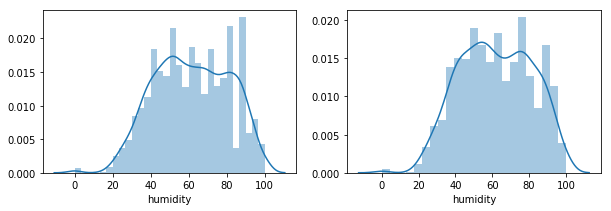

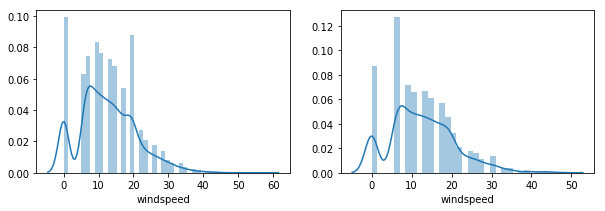

In [11]:
# The distribution of the numerical features on the train and test
draw_train_test_distribution('temp')
draw_train_test_distribution('atemp')
draw_train_test_distribution('humidity')
draw_train_test_distribution('windspeed')


The distribution of the scale features ('temp', 'atemp', 'humidity', 'windspeed') on the train and test coincides

In [12]:
def transformation(columnName, func = np.log1p):
    temp_train = pd.DataFrame(index=train_df.index)
    temp_train[columnName] = train_df[columnName].apply(func)

    temp_test = pd.DataFrame(index=test_df.index)
    temp_test[columnName] = test_df[columnName].apply(func)
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    sns.distplot(temp_train, ax = axes[0])
    sns.distplot(temp_test, ax = axes[1]);

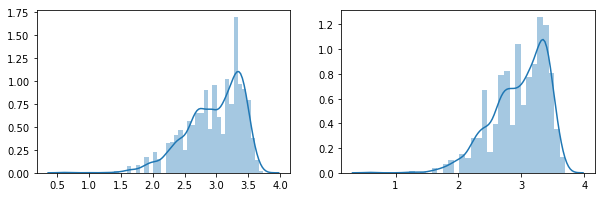

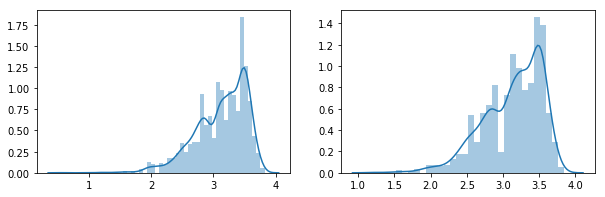

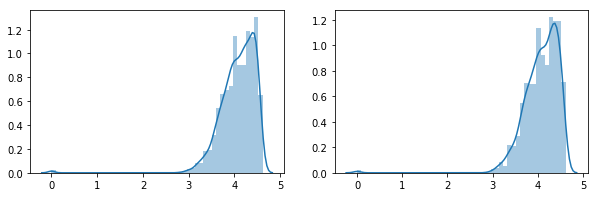

In [13]:
transformation('temp')
transformation('atemp')
transformation('humidity')

After the transformation of the distribution on the train_df and on the test_df began to resemble each other more

In [14]:
train_df['temp_tr'] = train_df['temp'].apply(np.log1p)
test_df['temp_tr'] = test_df['temp'].apply(np.log1p)
train_df['atemp_tr'] = train_df['atemp'].apply(np.log1p)
test_df['atemp_tr'] = test_df['atemp'].apply(np.log1p)
train_df['humidity_tr'] = train_df['humidity'].apply(np.log1p)
test_df['humidity_tr'] = test_df['humidity'].apply(np.log1p)

### Part 4. Insights and found dependencies

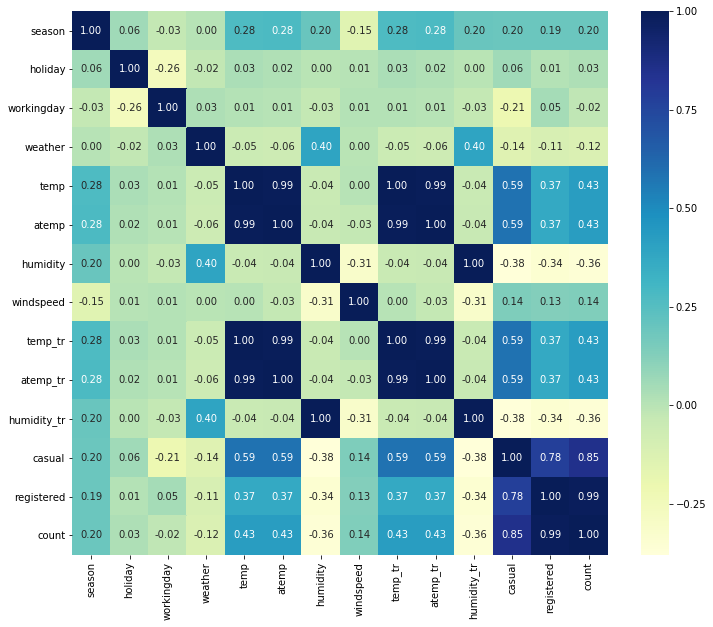

In [15]:
corr = train_df.join(y_train).corr('spearman')
plt.figure(figsize = ( 12 , 10 ))
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

    We can see a strong correlation between target columns (What was expected). Among customers, correlation with registered users is higher than with unregistered ones. In this case, unregistered looking more at the weather.
    Correlations temp/temp_tr, atemp/atemp_tr, humidity/humidity_tr are equals. I'll use *_tr features, because their distibutions into train/test are similar.
    **Idea: Build an ensemble using 3 models with different target!**
    'Holiday' has a low correlation with targets. I'll not use it.
    'Workingday' has a lower correlation with 'registered' and 'count' than with 'casual'
    'Windspeed' affects both registered and unregistered users
    The effect of 'temp' and 'atemp' is the same.
    

### Part 5. Metrics selection
According to the terms of [competition](https://www.kaggle.com/c/comp180bikeshare#evaluation) i will use Root Mean Squared Error (RMSE)

### Part 6. Model selection

The [course](https://www.coursera.org/learn/competitive-data-science) recommend using [Gradient boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) model as one of the most powerful. I want use Catboost library, because i want to understand it. From catboost library i 'll use CatBoostRegression, because current task is related to regression.

### Part 7. Data preprocessing

* I changed 'temp',  'atemp', 'humidity' features in part 3. 
* NaN is absent. 
* I will not use OHE because the CatBoostRegressor takes a list of categorical features as a parameter
* Scaling data in CatBoost will be auto

In [16]:
X_train = train_df.drop(['holiday', 'datetime', 'temp', 'atemp', 'humidity'], axis=1)
X_test = test_df.drop(['holiday', 'datetime', 'temp', 'atemp', 'humidity'], axis=1)

### Part 8. Cross-validation and adjustment of model hyperparameters

In [17]:
cat_features = [0, 1, 2]

X_train_cbr, X_test_cbr, y_train_cbr, y_test_cbr = train_test_split(X_train, y_train, test_size=0.3, random_state=17, shuffle=True)

In [18]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

# the number of random sets of hyperparameters
N_HYPEROPT_PROBES = 100

# hyperparameter sampling algorithm
HYPEROPT_ALGO = tpe.suggest

space ={
        'depth': hp.quniform("depth", 4, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
       }

def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    return params

def objective(space, target_column='count'):
    global obj_call_count, cur_best_rmse

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_acc={:7.5f}'.format(obj_call_count, cur_best_rmse) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = CatBoostRegressor(iterations=2000,
                              cat_features = cat_features,
                            learning_rate=params['learning_rate'],
                            depth=int(params['depth']),
                            use_best_model=True,
                            eval_metric='RMSE',
                            l2_leaf_reg=params['l2_leaf_reg'],
                            early_stopping_rounds=50,
                            random_seed=17,
                            verbose=False
                            )
    model.fit(X_train_cbr, y_train_cbr[target_column], 
              eval_set=(X_test_cbr, y_test_cbr[target_column]), 
              verbose=False)
    nb_trees = model.get_best_iteration()

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict(X_test_cbr)

    rmse = np.sqrt(mean_squared_error(y_test_cbr[target_column], y_pred))

    print('rmse={}, Params:{}, nb_trees={}\n'.format(rmse, params_str, nb_trees ))

    if rmse<cur_best_rmse:
        cur_best_rmse = rmse
        print(colorama.Fore.GREEN + 'NEW BEST RMSE={}'.format(cur_best_rmse) + colorama.Fore.RESET)


    return{'loss':rmse, 'status': STATUS_OK }

In [19]:
%%time
obj_call_count = 0
cur_best_rmse = np.inf

trials = Trials()
best = fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)


CatBoost objective call #1 cur_best_acc=    inf
Params: depth=6.0 l2_leaf_reg=9.162241059966508 learning_rate=0.11029754673317103
nb_trees=480
rmse=145.01128477405405, Params:depth=6.0 l2_leaf_reg=9.162241059966508 learning_rate=0.11029754673317103, nb_trees=480

NEW BEST RMSE=145.01128477405405

CatBoost objective call #2 cur_best_acc=145.01128
Params: depth=10.0 l2_leaf_reg=5.724509161849184 learning_rate=0.06224506493131391
nb_trees=398
rmse=144.71057146309488, Params:depth=10.0 l2_leaf_reg=5.724509161849184 learning_rate=0.06224506493131391, nb_trees=398

NEW BEST RMSE=144.71057146309488

CatBoost objective call #3 cur_best_acc=144.71057
Params: depth=7.0 l2_leaf_reg=6.860648877422373 learning_rate=0.23900279053690465
nb_trees=146
rmse=144.8364098482692, Params:depth=7.0 l2_leaf_reg=6.860648877422373 learning_rate=0.23900279053690465, nb_trees=146


CatBoost objective call #4 cur_best_acc=144.71057
Params: depth=6.0 l2_leaf_reg=5.0723531000176605 learning_rate=0.055663490360050125

nb_trees=131
rmse=145.08833065723064, Params:depth=10.0 l2_leaf_reg=9.3848178488215 learning_rate=0.1787208387888453, nb_trees=131


CatBoost objective call #32 cur_best_acc=144.43029
Params: depth=9.0 l2_leaf_reg=8.289169560998735 learning_rate=0.13774620011307132
nb_trees=256
rmse=145.02798301553528, Params:depth=9.0 l2_leaf_reg=8.289169560998735 learning_rate=0.13774620011307132, nb_trees=256


CatBoost objective call #33 cur_best_acc=144.43029
Params: depth=10.0 l2_leaf_reg=7.420709322375874 learning_rate=0.2240876451214591
nb_trees=274
rmse=145.11576838465385, Params:depth=10.0 l2_leaf_reg=7.420709322375874 learning_rate=0.2240876451214591, nb_trees=274


CatBoost objective call #34 cur_best_acc=144.43029
Params: depth=7.0 l2_leaf_reg=5.684481350674522 learning_rate=0.050632720084829726
nb_trees=437
rmse=145.3315581956136, Params:depth=7.0 l2_leaf_reg=5.684481350674522 learning_rate=0.050632720084829726, nb_trees=437


CatBoost objective call #35 cur_best_acc=144.43029
Params: dep

nb_trees=128
rmse=145.61247589788286, Params:depth=9.0 l2_leaf_reg=7.729832872855775 learning_rate=0.3073316136478665, nb_trees=128


CatBoost objective call #63 cur_best_acc=144.43029
Params: depth=10.0 l2_leaf_reg=9.518917442874896 learning_rate=0.08053455657649686
nb_trees=443
rmse=145.1077341169676, Params:depth=10.0 l2_leaf_reg=9.518917442874896 learning_rate=0.08053455657649686, nb_trees=443


CatBoost objective call #64 cur_best_acc=144.43029
Params: depth=6.0 l2_leaf_reg=7.245156735198671 learning_rate=0.09994191725476097
nb_trees=198
rmse=145.54818986689392, Params:depth=6.0 l2_leaf_reg=7.245156735198671 learning_rate=0.09994191725476097, nb_trees=198


CatBoost objective call #65 cur_best_acc=144.43029
Params: depth=8.0 l2_leaf_reg=6.742887363930684 learning_rate=0.18058751596119568
nb_trees=239
rmse=144.84433609439233, Params:depth=8.0 l2_leaf_reg=6.742887363930684 learning_rate=0.18058751596119568, nb_trees=239


CatBoost objective call #66 cur_best_acc=144.43029
Params: de

nb_trees=309
rmse=145.1521968062212, Params:depth=7.0 l2_leaf_reg=7.128266630592688 learning_rate=0.12397060121704302, nb_trees=309


CatBoost objective call #94 cur_best_acc=144.43029
Params: depth=10.0 l2_leaf_reg=7.8632368086984945 learning_rate=0.1469632640056585
nb_trees=122
rmse=144.90379702332206, Params:depth=10.0 l2_leaf_reg=7.8632368086984945 learning_rate=0.1469632640056585, nb_trees=122


CatBoost objective call #95 cur_best_acc=144.43029
Params: depth=10.0 l2_leaf_reg=8.697116850767104 learning_rate=0.13544159624736146
nb_trees=245
rmse=144.37519868411036, Params:depth=10.0 l2_leaf_reg=8.697116850767104 learning_rate=0.13544159624736146, nb_trees=245

NEW BEST RMSE=144.37519868411036

CatBoost objective call #96 cur_best_acc=144.37520
Params: depth=10.0 l2_leaf_reg=8.728970322345344 learning_rate=0.16998424453808686
nb_trees=165
rmse=145.73722098683078, Params:depth=10.0 l2_leaf_reg=8.728970322345344 learning_rate=0.16998424453808686, nb_trees=165


CatBoost objective call

In [20]:
print('The best params:')
print( best )

The best params:
{'depth': 10.0, 'l2_leaf_reg': 8.697116850767104, 'learning_rate': 0.13544159624736146}


In [21]:
cbr = CatBoostRegressor(random_seed=17, 
                        eval_metric='RMSE', 
                        iterations=2000, 
                        max_depth=best['depth'], 
                        early_stopping_rounds=50, 
                        learning_rate=best['learning_rate'],
                        l2_leaf_reg=best['l2_leaf_reg'],
                       use_best_model=True)
cbr.fit(X_train_cbr, y_train_cbr['count'], 
       eval_set=(X_test_cbr, y_test_cbr['count']), 
       cat_features=cat_features,
       silent=True,
       plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

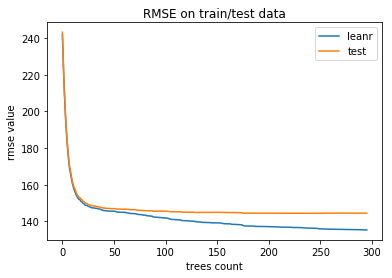

In [25]:
rmse_learn = cbr.evals_result_['learn']['RMSE']
rmse_test = cbr.evals_result_['validation_0']['RMSE']

plt.plot(rmse_learn)
plt.plot(rmse_test)
plt.title('RMSE on train/test data')
plt.xlabel('trees count')
plt.ylabel('rmse value')
plt.legend(['leanr', 'test']);

In [26]:
#Get important features
cbr.feature_importances_

array([ 8.69045726,  5.04970729,  4.92076645,  6.94062184, 21.6302066 ,
       19.58736656, 33.180874  ])

Most important features are 'humidity_tr', 'atemp_tr' and 'temp_tr'

###  Part 9. Creation of new features and description of this process


Add new features from 'datetime'

In [27]:
train_df['hour'] = train_df['datetime'].apply(lambda ts: ts.hour)
test_df['hour'] = test_df['datetime'].apply(lambda ts: ts.hour) 

train_df['weekday'] = train_df['datetime'].apply(lambda ts: ts.isoweekday())
test_df['weekday'] = test_df['datetime'].apply(lambda ts: ts.isoweekday())

train_df['month'] = train_df['datetime'].apply(lambda ts: ts.month)
test_df['month'] = test_df['datetime'].apply(lambda ts: ts.month) 

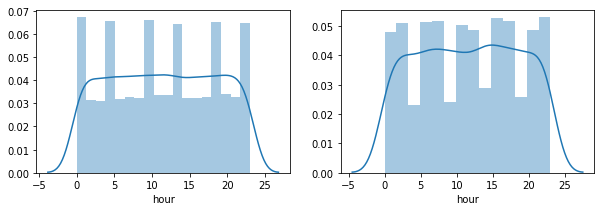

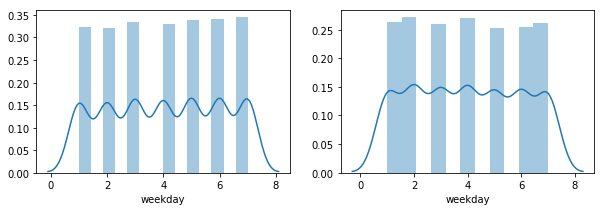

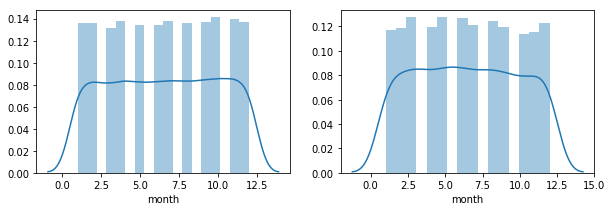

In [28]:
draw_train_test_distribution('hour')
draw_train_test_distribution('weekday');
draw_train_test_distribution('month');

Disributions in train and test datasets are equale.

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


18055

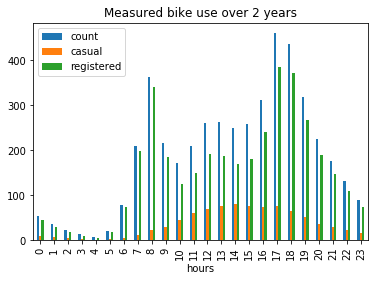

In [29]:
hours_mean_count = {}
hours_mean_casual = {}
hours_mean_registered = {}

hours_mean ={}
hours = np.unique(train_df['hour'])
print("hours:",hours)

temp_train_df =  train_df.join(y_train)

for h in hours:
    hours_mean_count[h] = temp_train_df.loc[temp_train_df['hour'] == h]['count'].mean()
    hours_mean_casual[h] = temp_train_df.loc[temp_train_df['hour'] == h]['casual'].mean()
    hours_mean_registered[h] = temp_train_df.loc[temp_train_df['hour'] == h]['registered'].mean()
    
    hours_mean[h] = [temp_train_df.loc[temp_train_df['hour'] == h]['count'].mean(),
                    temp_train_df.loc[temp_train_df['hour'] == h]['casual'].mean(),
                    temp_train_df.loc[temp_train_df['hour'] == h]['registered'].mean()]
    
hours_df = pd.DataFrame.from_dict(hours_mean, orient='index',
                        columns=['count', 'casual', 'registered'])  
hours_df['hours'] = hours

hours_df.plot(x='hours', y=['count', 'casual', 'registered'], kind='bar', 
              title = 'Measured bike use over 2 years',  legend = True );

del temp_train_df
gc.collect()

Ok. It makes sense to make features by the hour: night (23-0-6),  day (7-22)

In [30]:
train_df['night'] = train_df['hour'].apply(lambda h: 1 if (h>=23) | (h<=6) else 0)
train_df['day'] = train_df['hour'].apply(lambda h: 1 if (h<23) & (h>6) else 0)

test_df['night'] = test_df['hour'].apply(lambda h: 1 if (h>=23) | (h<=6) else 0)
test_df['day'] = test_df['hour'].apply(lambda h: 1 if (h<23) & (h>6) else 0)

I like trigonimetry)) [Here](https://habr.com/company/ods/blog/325422/#data-i-vremya) and [here](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a) is a great example of how to use trigonometry. I'll modify it a bit.

In [31]:
def make_harmonic_features(value, period=24):
    new_value = value * 2 * np.pi / period
    return np.cos(new_value), np.sin(new_value)

train_df['hour_cos'], train_df['hour_sin'] = make_harmonic_features(train_df['hour'])
test_df['hour_cos'], test_df['hour_sin'] = make_harmonic_features(test_df['hour'])


In [32]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,temp_tr,atemp_tr,humidity_tr,hour,weekday,month,night,day,hour_cos,hour_sin
437,2011-02-03 19:00:00,1,0,1,1,8.20,12.880,40,0.0000,2.219203,2.630449,3.713572,19,4,2,0,1,0.258819,-9.659258e-01
5230,2012-02-12 12:00:00,1,0,0,1,5.74,3.790,39,43.0006,1.908060,1.566530,3.688879,12,7,2,0,1,-1.000000,1.224647e-16
4928,2012-01-15 21:00:00,1,0,0,1,6.56,8.335,40,11.0014,2.022871,2.233771,3.713572,21,7,1,0,1,0.707107,-7.071068e-01
6110,2012-05-01 07:00:00,2,0,1,2,20.50,24.240,94,16.9979,3.068053,3.228430,4.553877,7,2,5,0,1,-0.258819,9.659258e-01
8050,2012-10-02 03:00:00,4,0,1,2,22.14,25.760,88,12.9980,3.141563,3.286908,4.488636,3,2,10,1,0,0.707107,7.071068e-01


### Part 10. Plotting training and validation curves

Build new model with new params

In [33]:
X_train = train_df.drop(['holiday', 'datetime', 'temp', 'atemp', 'humidity'], axis=1)
X_test = test_df.drop(['holiday', 'datetime', 'temp', 'atemp', 'humidity'], axis=1)

In [34]:
X_train.head()

,season,workingday,weather,windspeed,temp_tr,atemp_tr,humidity_tr,hour,weekday,month,night,day,hour_cos,hour_sin
437,1,1,1,0.0000,2.219203,2.630449,3.713572,19,4,2,0,1,0.258819,-9.659258e-01
5230,1,0,1,43.0006,1.908060,1.566530,3.688879,12,7,2,0,1,-1.000000,1.224647e-16
4928,1,0,1,11.0014,2.022871,2.233771,3.713572,21,7,1,0,1,0.707107,-7.071068e-01
6110,2,1,2,16.9979,3.068053,3.228430,4.553877,7,2,5,0,1,-0.258819,9.659258e-01
8050,4,1,2,12.9980,3.141563,3.286908,4.488636,3,2,10,1,0,0.707107,7.071068e-01


In [35]:
cat_features = [0, 1, 2, 7, 8, 9, 10, 11]

X_train_cbr, X_test_cbr, y_train_cbr, y_test_cbr = train_test_split(X_train, y_train, test_size=0.3, random_state=17, shuffle=True)

In [36]:
%%time
obj_call_count = 0
cur_best_rmse = np.inf

trials = Trials()
best = fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)


CatBoost objective call #1 cur_best_acc=    inf
Params: depth=5.0 l2_leaf_reg=3.6682087933198284 learning_rate=0.07909205370984926
nb_trees=902
rmse=68.33381735050217, Params:depth=5.0 l2_leaf_reg=3.6682087933198284 learning_rate=0.07909205370984926, nb_trees=902

NEW BEST RMSE=68.33381735050217

CatBoost objective call #2 cur_best_acc=68.33382
Params: depth=6.0 l2_leaf_reg=8.518864365726454 learning_rate=0.47087299281034634
nb_trees=341
rmse=68.40904379257363, Params:depth=6.0 l2_leaf_reg=8.518864365726454 learning_rate=0.47087299281034634, nb_trees=341


CatBoost objective call #3 cur_best_acc=68.33382
Params: depth=7.0 l2_leaf_reg=7.919130742865397 learning_rate=0.21083354696159431
nb_trees=277
rmse=66.168225887532, Params:depth=7.0 l2_leaf_reg=7.919130742865397 learning_rate=0.21083354696159431, nb_trees=277

NEW BEST RMSE=66.168225887532

CatBoost objective call #4 cur_best_acc=66.16823
Params: depth=5.0 l2_leaf_reg=1.113323419690216 learning_rate=0.26001945023393747
nb_trees=225

nb_trees=1125
rmse=65.46997061191507, Params:depth=8.0 l2_leaf_reg=8.592236056628881 learning_rate=0.07481055095293093, nb_trees=1125


CatBoost objective call #32 cur_best_acc=64.79170
Params: depth=10.0 l2_leaf_reg=9.357869862537829 learning_rate=0.05353525685614717
nb_trees=1192
rmse=64.86315281612426, Params:depth=10.0 l2_leaf_reg=9.357869862537829 learning_rate=0.05353525685614717, nb_trees=1192


CatBoost objective call #33 cur_best_acc=64.79170
Params: depth=4.0 l2_leaf_reg=8.033457598496545 learning_rate=0.09832482467429704
nb_trees=971
rmse=69.38126861201891, Params:depth=4.0 l2_leaf_reg=8.033457598496545 learning_rate=0.09832482467429704, nb_trees=971


CatBoost objective call #34 cur_best_acc=64.79170
Params: depth=9.0 l2_leaf_reg=9.963617909574348 learning_rate=0.3028589511337448
nb_trees=226
rmse=66.5063390038465, Params:depth=9.0 l2_leaf_reg=9.963617909574348 learning_rate=0.3028589511337448, nb_trees=226


CatBoost objective call #35 cur_best_acc=64.79170
Params: depth=1

nb_trees=659
rmse=65.55956291819227, Params:depth=8.0 l2_leaf_reg=9.625142105283636 learning_rate=0.14878979849694146, nb_trees=659


CatBoost objective call #63 cur_best_acc=64.79170
Params: depth=5.0 l2_leaf_reg=4.63916562631935 learning_rate=0.08128188085371227
nb_trees=843
rmse=68.00484044482793, Params:depth=5.0 l2_leaf_reg=4.63916562631935 learning_rate=0.08128188085371227, nb_trees=843


CatBoost objective call #64 cur_best_acc=64.79170
Params: depth=10.0 l2_leaf_reg=9.043356073653918 learning_rate=0.05613123365992966
nb_trees=828
rmse=65.99462558562054, Params:depth=10.0 l2_leaf_reg=9.043356073653918 learning_rate=0.05613123365992966, nb_trees=828


CatBoost objective call #65 cur_best_acc=64.79170
Params: depth=7.0 l2_leaf_reg=7.543939115943811 learning_rate=0.18328286010810194
nb_trees=717
rmse=66.77702851055581, Params:depth=7.0 l2_leaf_reg=7.543939115943811 learning_rate=0.18328286010810194, nb_trees=717


CatBoost objective call #66 cur_best_acc=64.79170
Params: depth=9.0 

nb_trees=702
rmse=65.50004846091457, Params:depth=10.0 l2_leaf_reg=5.175619961741978 learning_rate=0.0676379462903642, nb_trees=702


CatBoost objective call #94 cur_best_acc=64.67393
Params: depth=6.0 l2_leaf_reg=8.735062069007693 learning_rate=0.06348447645872213
nb_trees=1706
rmse=66.19551962074345, Params:depth=6.0 l2_leaf_reg=8.735062069007693 learning_rate=0.06348447645872213, nb_trees=1706


CatBoost objective call #95 cur_best_acc=64.67393
Params: depth=8.0 l2_leaf_reg=2.5963006016413672 learning_rate=0.1262353894127347
nb_trees=690
rmse=65.84965927529257, Params:depth=8.0 l2_leaf_reg=2.5963006016413672 learning_rate=0.1262353894127347, nb_trees=690


CatBoost objective call #96 cur_best_acc=64.67393
Params: depth=9.0 l2_leaf_reg=8.281813696331865 learning_rate=0.05677436072170626
nb_trees=1350
rmse=65.3694451777984, Params:depth=9.0 l2_leaf_reg=8.281813696331865 learning_rate=0.05677436072170626, nb_trees=1350


CatBoost objective call #97 cur_best_acc=64.67393
Params: depth=1

In [37]:
print('The best params:')
print(best)

The best params:
{'depth': 10.0, 'l2_leaf_reg': 7.565831147201584, 'learning_rate': 0.09433881110620687}


In [38]:
cbr = CatBoostRegressor(random_seed=17, 
                        eval_metric='RMSE', 
                        iterations=2000, 
                        max_depth=best['depth'], 
                        early_stopping_rounds=50, 
                        learning_rate=best['learning_rate'],
                        l2_leaf_reg=best['l2_leaf_reg'])
cbr.fit(X_train_cbr, y_train_cbr['count'], 
       eval_set=(X_test_cbr, y_test_cbr['count']), 
       cat_features=cat_features,
       silent=True,
       plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

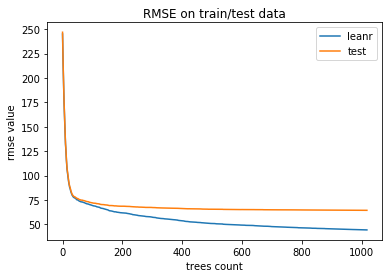

In [39]:
rmse_learn = cbr.evals_result_['learn']['RMSE']
rmse_test = cbr.evals_result_['validation_0']['RMSE']

plt.plot(rmse_learn)
plt.plot(rmse_test)
plt.title('RMSE on train/test data')
plt.xlabel('trees count')
plt.ylabel('rmse value')
plt.legend(['leanr', 'test']);

### Part 11. Prediction for test or hold-out samples 

In [40]:
%%time
cbr = CatBoostRegressor(random_seed=17, 
                        eval_metric='RMSE', 
                        iterations=2000, 
                        max_depth=best['depth'], 
#                         early_stopping_rounds=50, #because fit without eval_set
                        learning_rate=best['learning_rate'],
                        l2_leaf_reg=best['l2_leaf_reg'])
cbr.fit(X_train, y_train['count'], 
       cat_features=cat_features,
       silent=True,
       plot=False);

CPU times: user 7min 57s, sys: 18.3 s, total: 8min 16s
Wall time: 2min 13s


In [41]:
y_pred = cbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test['count'], y_pred))
print('RMSE = ', rmse)

RMSE =  64.31098326059245


**RMSE for hold_out samples coincides with the RMSE on cross-validation!!!**

### Part 12. Conclusions 
* New features significantly improved the result. 'cbr.feature_importances_' shows us the most important parameters. If you select new features from them, you can get a better model.
* Some features can degrade the result and it would be necessary to find them and remove them from the model.
* Here you can also apply an ensemble of models based on different targets ('casual', 'registered' and 'count'). Also try other libraries (lightgbm, XGBoost) and compare results. And can also apply an ensemble of models based on different libraries )))
* The implemented functions **objective**  and **get_catboost_params** for setting hyperparameters can be used in other projects. I think this is a good start for creating a more flexible library that can be used in Kaggle competitions
* I used CPU, but GPU can be used in catboost. 